# GPT Model Testing & Evaluation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from rouge import Rouge
from bert_score import BERTScorer

from llm import append_llm_output, generate_llm_output
from prompts import system_prompt_topic, topic_introduction, topic_instructions
from prompts import system_prompt_sentiment, sentiment_introduction, sentiment_instructions

In [6]:
# Create validation set
df = pd.read_csv('data/news_cleaned.csv')
valid_df = df[['matchdatetime', 'station', 'snippet']].sample(250).sort_index(ascending=True)
valid_df['gpt_topic_label'] = pd.NaT
valid_df['Rank'] = range(1, len(valid_df) + 1)
valid_df.head()

,matchdatetime,station,snippet,gpt_topic_label,Rank
316,2013-01-26 23:24:33,FOXNEWS,class and climate change -- those are things h...,NaT,1
393,2013-01-21 20:40:32,FOXNEWS,"reaction, the strong reaction, on both sides t...",NaT,2
593,2017-11-06 04:32:51,BBCNEWS,threats from climate change risks to nuclear s...,NaT,3
666,2017-11-16 05:15:00,BBCNEWS,0ur headlines: a new report is warning that cl...,NaT,4
1057,2017-05-26 02:30:41,BBCNEWS,"france, germany, italy, japan, the united king...",NaT,5


In [7]:
# # Read validation set
# valid_df = pd.read_csv('data/topic_validations.csv', index_col=0)
# valid_df = valid_df.drop(columns=['snippet_no_climate'])
# valid_df.head()

## Topic Modeling

### Label Snippets

In [8]:
topic_payload = {
    "system_prompt": system_prompt_topic,
    "introduction": topic_introduction,
    "instruction": topic_instructions
}

In [12]:
# Update the DataFrame with topic labels
result_col = 'gpt_topic_label'
gpt_output_df = append_llm_output(df=valid_df, payload=topic_payload, result_col=result_col)

# Display the updated DataFrame
gpt_output_df

,matchdatetime,station,snippet,gpt_topic_label,Rank
316,2013-01-26 23:24:33,FOXNEWS,class and climate change -- those are things h...,Unknown,1
393,2013-01-21 20:40:32,FOXNEWS,"reaction, the strong reaction, on both sides t...",Unknown,2
593,2017-11-06 04:32:51,BBCNEWS,threats from climate change risks to nuclear s...,Unknown,3
666,2017-11-16 05:15:00,BBCNEWS,0ur headlines: a new report is warning that cl...,inevitable climate change,4
1057,2017-05-26 02:30:41,BBCNEWS,"france, germany, italy, japan, the united king...",global fight against terrorism,5
...,...,...,...,...,...
88085,2016-02-05 05:52:33,MSNBC,invest in low income countries around the worl...,Unknown,246
88105,2016-02-08 18:08:41,MSNBC,climate change. how can you run for president ...,climate change denial,247
89974,2019-07-26 20:00:46,BBCNEWS,number of civilians every time a week and the ...,wildfire crisis,248
90170,2017-08-10 06:41:10,BBCNEWS,before becoming an oscar-winning documentary m...,global warming documentary,249


### Analyse Topic Labels

In [10]:
# gpt_output_label_df = pd.read_csv("data/topic_labels_and_sentiment_2024-04-06.csv")

In [13]:
# Value counts of labels
top_10_labels = gpt_output_df['gpt_topic_label'].value_counts().nlargest(10)
top_10_labels

gpt_topic_label
Unknown                         97
greenhouse gas reduction        14
climate change denial            6
global warming impact            5
fight against climate change     4
climate change impact            4
climate impact assessment        4
climate change effects           3
global warming hoax              2
global warming effects           2
Name: count, dtype: int64

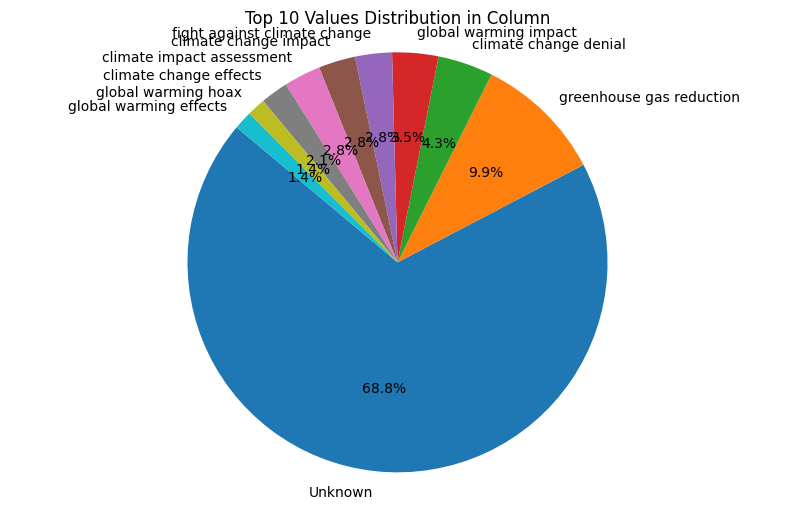

In [14]:
# Value counts of labels
top_10_labels = gpt_output_df['gpt_topic_label'].value_counts().nlargest(10)

# Creating the pie chart
plt.figure(figsize=(10, 6))
plt.pie(top_10_labels, labels=top_10_labels.index, autopct='%1.1f%%', startangle=140)
plt.title('Top 10 Values Distribution in Column')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [8]:
gpt_topic_list = gpt_output_df.loc[gpt_output_df['gpt_topic_label'] != 'Unknown', 'gpt_topic_label'].unique()
# gpt_topic_list

In [10]:
# Vectorization with TF-IDF
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(gpt_topic_list)

# Clustering with K-Means
num_clusters = 5  # Desired number of categories
km = KMeans(n_clusters=num_clusters, random_state=42)
km.fit(tfidf_matrix)

# Assign each topic label to a category based on clustering result
categories = km.labels_

# Creating a dictionary to map topic labels to their categories
topic_to_category = {label: category for label, category in zip(gpt_topic_list, categories)}

# Print the categorized topic labels
for category in range(num_clusters):
    print(f"\nCategory {category + 1}:")
    for topic, cat in topic_to_category.items():
        if cat == category:
            print(f" - {topic}")


/Users/bryanflores/.local/share/virtualenvs/AutoLabeling-Gmkuf0MD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)



Category 1:
 - carbon absorption
 - carbon pollution reduction
 - carbon emissions impact
 - carbon rich soil
 - carbon dioxide reduction
 - carbon reduction
 - carbon dioxide levels
 - carbon dioxide utilization

Category 2:
 - hottest year record
 - greenhouse gas reduction
 - marine tourism impact
 - amazon fires crisis
 - trade opportunities
 - globalisation discussion
 - severe weather events
 - forest management blame
 - paris agreement implementation
 - environmental issues career
 - air and water quality
 - reduce emissions
 - melting glacier revelation
 - fossil fuel impact
 - dry periods in history
 - EPA administrator statement
 - environmental program advancements
 - earth preservation
 - supreme court judges
 - national security threat
 - greenhouse gas regulation
 - food supply threat
 - coal mining plans
 - Paris Agreement Implementation
 - young people striking
 - fossil fuel regulation
 - clean technology competitiveness
 - greenhouse gas emission
 - climate research 

/Users/bryanflores/.local/share/virtualenvs/AutoLabeling-Gmkuf0MD/lib/python3.8/site-packages/threadpoolctl.py:1195: RuntimeWarning: libc not found. The ctypes module in Python 3.8 is maybe too old for this OS.
  warnings.warn(


In [16]:
# function to calculate the Rouge score
def get_rouge_scores(text1, text2):
    rouge = Rouge()
    return rouge.get_scores(text1, text2)


rouge_scores_out = []

topic_1 = 'emergency act intention'
topic_2 = 'national emergency response'
topic_ref = 'climate change national emergency'

# Calculate the ROUGE scores for both summaries using reference
eval_1_rouge = get_rouge_scores(topic_1, topic_ref)
eval_2_rouge = get_rouge_scores(topic_2, topic_ref)

for metric in ["rouge-1", "rouge-2", "rouge-l"]:
    for label in ["F-Score"]:
        eval_1_score = eval_1_rouge[0][metric][label[0].lower()]
        eval_2_score = eval_2_rouge[0][metric][label[0].lower()]

        row = {
            "Metric": f"{metric} ({label})",
            "Topic 1": eval_1_score,
            "Topic 2": eval_2_score,
        }
        rouge_scores_out.append(row)


def highlight_max(s):
    is_max = s == s.max()
    return [
        "background-color: blue" if v else "background-color: black"
        for v in is_max
    ]


rouge_scores_out = (
    pd.DataFrame(rouge_scores_out)
    .set_index("Metric")
    .style.apply(highlight_max, axis=1)
)

rouge_scores_out

,Topic 1,Topic 2
Metric,,
rouge-1 (F-Score),0.285714,0.571429
rouge-2 (F-Score),0.000000,0.400000
rouge-l (F-Score),0.285714,0.571429


In [24]:
# Instantiate the BERTScorer object for English language
scorer = BERTScorer(lang="en")

# Calculate BERTScore for the summary 1 against the excerpt
# P1, R1, F1_1 represent Precision, Recall, and F1 Score respectively
P1, R1, F1_1 = scorer.score([topic_1], [topic_ref])

# Calculate BERTScore for summary 2 against the excerpt
# P2, R2, F2_2 represent Precision, Recall, and F1 Score respectively
P2, R2, F2_2 = scorer.score([topic_2], [topic_ref])

print("Topic 1 F1 Score:", F1_1.tolist()[0])
print("Topic 2 F1 Score:", F2_2.tolist()[0])

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Topic 1 F1 Score: 0.8404699563980103
Topic 2 F1 Score: 0.8725161552429199


### Re-Test 'Unknown' Labels

In [5]:
topic_payload = {
    "system_prompt": system_prompt_topic,
    "introduction": topic_introduction,
    "instruction": topic_instructions,
    "snippet": valid_df['snippet'][1764]
}
topic_payload["snippet"]

"arctic is warming at more than twice the rate of the global average.' secretary tillerson made clear the trump administration is still weighing its approach on climate change issues. we are not going to rush to make a decision paired we are"

In [7]:
generate_llm_output(topic_payload)

'Unknown'

In [107]:
# Rename 'Unknown's 
gpt_output_df.at[83672, 'gpt_topic_label'] = 'climate action and finance'

In [108]:
gpt_output_df.iloc[40:50]

,matchdatetime,station,snippet,Rank,gpt_topic_label
74595,2019-11-28 19:36:42,BBCNEWS,perhaps thinking that manifestos might makea m...,41,climate change debate
75022,2015-08-03 18:19:40,FOXNEWS,able to reverse and we may not be able to adap...,42,adaptation challenge
76913,2019-04-09 23:42:25,FOXNEWS,going to go on another 30 years and we'll thin...,43,air quality improvement
81813,2010-11-17 07:41:54,MSNBC,there are no republican senators who will argu...,44,Republican senators' opinions
83069,2019-12-15 22:19:19,BBCNEWS,the world has already warmed byjust over one d...,45,world temperature rise
83543,2019-12-10 23:01:35,BBCNEWS,aung san suu kyi defence are country myanmar a...,46,Unknown
83672,2019-12-30 18:04:26,BBCNEWS,next year as the un's special envoy for climat...,47,climate action and finance
87245,2016-03-15 05:30:33,MSNBC,to fight a war on two fronts in a very short p...,48,war on emissions
90185,2017-08-03 23:18:48,BBCNEWS,greenhouse gases. the moisture in the area is ...,49,moisture level increase
90839,2012-02-25 15:24:25,CNN,was governor of massachusetts and talk about h...,50,Unknown


In [7]:
# Assigning human labels to 'Unknown' labeled snippets
# df['snippet'][182]  # indoor air pollution
# df['snippet'][5177]  # obama climate speech
# df['snippet'][7015]   # trump global stance
# df['snippet'][2031]  # Unknown -- multiple topics
# df['snippet'][4962]  # flat earth congresswoman

"more. a real pattern today. exhibit a. global warming. new york congresswoman marianne berkeover has been dubbed a member of the flat earth for her denial of global warming. let's listen to her. this trade bill is a tax on"

In [113]:
# Store LLM results
# gpt_output_df.to_csv('data/topic_labels.csv')

## Sentiment Analysis

In [2]:
# Import topic label dataframe
gpt_label_df = pd.read_csv('data/topic_labels.csv', index_col=0)
gpt_label_df['gpt_sentiment'] = pd.NaT
gpt_label_df.head()

,matchdatetime,station,snippet,Rank,gpt_topic_label,gpt_sentiment
1764,2017-05-11 22:13:08,FOXNEWS,arctic is warming at more than twice the rate ...,1,arctic warming rate,NaT
4080,2013-02-17 10:17:04,FOXNEWS,plus unlimited talk and text. now save $50 on ...,2,combat climate change,NaT
5209,2017-12-06 13:18:46,BBCNEWS,"good, more intense winds are forecast in the c...",3,scientists say climate change,NaT
5646,2019-09-13 19:26:08,BBCNEWS,it's the most powerful greenhouse gas known to...,4,sulphur hexa fluoride harm,NaT
6631,2019-09-19 18:26:05,BBCNEWS,a new battle ground opens up in colorado over ...,5,environmental regulations battle,NaT


In [4]:
sentiment_payload = {
    "system_prompt": system_prompt_sentiment,
    "introduction": sentiment_introduction,
    "instruction": sentiment_instructions,
    # "snippet": gpt_label_df['snippet'][1764]
}
# print(sentiment_payload['snippet'])

In [9]:
# Single snippet test
generate_llm_output(sentiment_payload)

'Negative'

In [5]:
# Update the DataFrame with sentiment classification
result_col = 'gpt_sentiment'
gpt_output_df = append_llm_output(df=gpt_label_df, payload=sentiment_payload, result_col=result_col)

In [10]:
gpt_output_df = gpt_output_df.rename(columns={'gpt_topic_label': 'gpt_topic_label_0401',
                                              'gpt_sentiment': 'gpt_sentiment_0401'})

In [11]:
gpt_output_df.iloc[0:50]

,matchdatetime,station,snippet,Rank,gpt_topic_label_0401,gpt_sentiment_0401
1764,2017-05-11 22:13:08,FOXNEWS,arctic is warming at more than twice the rate ...,1,arctic warming rate,Negative
4080,2013-02-17 10:17:04,FOXNEWS,plus unlimited talk and text. now save $50 on ...,2,combat climate change,Positive
5209,2017-12-06 13:18:46,BBCNEWS,"good, more intense winds are forecast in the c...",3,scientists say climate change,Negative
5646,2019-09-13 19:26:08,BBCNEWS,it's the most powerful greenhouse gas known to...,4,sulphur hexa fluoride harm,Negative
6631,2019-09-19 18:26:05,BBCNEWS,a new battle ground opens up in colorado over ...,5,environmental regulations battle,Negative
9164,2018-06-09 22:53:03,CNN,increasingly powerful gulf storms caused by ri...,6,gulf storms impact,Negative
10142,2015-11-30 16:00:35,FOXNEWS,bill: you'll find out soon. we'll see you tomo...,7,Unknown,Positive
11453,2019-08-19 08:21:56,BBCNEWS,"but as wider society, will be the biggest chal...",8,Somerset Levels Vulnerability,Negative
12520,2013-03-15 17:05:56,FOXNEWS,in front and start leading the charge on this....,9,Unknown,Neutral
13595,2017-03-19 19:53:24,FOXNEWS,"the calf today standards, and you can see dona...",10,putting ourselves at disadvantage,Negative


## Store Results

In [26]:
from datetime import date

gpt_output_df.to_csv(f'data/topic_labels_and_sentiment_{date.today()}.csv')